# 신경망 모델 훈련 (파이토치)

In [2]:
from torchvision.datasets import FashionMNIST

fm_train = FashionMNIST(root='.', train=True, download=True)
fm_test = FashionMNIST(root='.', train=False, download=True)

In [3]:
train_input = fm_train.data
train_target = fm_train.targets

In [4]:
train_scaled = train_input / 255.0

In [5]:
from sklearn.model_selection import train_test_split

train_scaled, val_scaled, train_target, val_target = train_test_split(
    train_scaled, train_target, test_size=0.2, random_state=42)

In [6]:
import torch.nn as nn

model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(784, 100),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(100, 10)
)

In [7]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=100, bias=True)
  (2): ReLU()
  (3): Dropout(p=0.3, inplace=False)
  (4): Linear(in_features=100, out_features=10, bias=True)
)

In [8]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

In [9]:
train_hist = []
val_hist = []
patience = 2
best_loss = -1
early_stopping_counter = 0

epochs = 20
batches = int(len(train_scaled)/32)
for epoch in range(epochs):
    model.train()
    train_loss = 0
    for i in range(batches):
        inputs = train_scaled[i*32:(i+1)*32].to(device)
        targets = train_target[i*32:(i+1)*32].to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
                                
    model.eval()
    val_loss = 0
    with torch.no_grad():
        val_scaled = val_scaled.to(device)
        val_target = val_target.to(device)
        outputs = model(val_scaled)
        loss = criterion(outputs, val_target)
        val_loss = loss.item()
        
    train_hist.append(train_loss/batches)
    val_hist.append(val_loss)
    print(f"에포크:{epoch+1},",
          f"훈련 손실:{train_loss/batches:.4f}, 검증 손실:{val_loss:.4f}")
    
    if best_loss == -1 or val_loss <best_loss:
        best_loss = val_loss
        early_stopping_counter = 0
        torch.save(model.state_dict(), 'best_model.pt')
    else:
        early_stopping_counter += 1
        if early_stopping_counter >= patience:
            print(f"{epoch+1}번째 에포크에서 조기 종료되었습니다.")
            break

에포크:1, 훈련 손실:0.6115, 검증 손실:0.4389
에포크:2, 훈련 손실:0.4432, 검증 손실:0.3892
에포크:3, 훈련 손실:0.4063, 검증 손실:0.3678
에포크:4, 훈련 손실:0.3849, 검증 손실:0.3642
에포크:5, 훈련 손실:0.3692, 검증 손실:0.3558
에포크:6, 훈련 손실:0.3556, 검증 손실:0.3516
에포크:7, 훈련 손실:0.3454, 검증 손실:0.3429
에포크:8, 훈련 손실:0.3360, 검증 손실:0.3376
에포크:9, 훈련 손실:0.3293, 검증 손실:0.3339
에포크:10, 훈련 손실:0.3219, 검증 손실:0.3379
에포크:11, 훈련 손실:0.3161, 검증 손실:0.3438
11번째 에포크에서 조기 종료되었습니다.


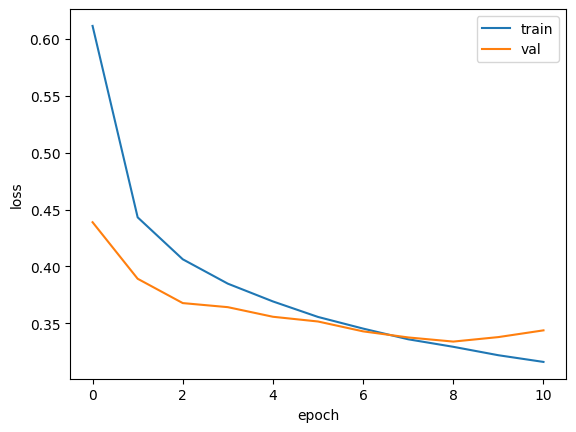

In [10]:
import matplotlib.pyplot as plt

plt.plot(train_hist, label='train')
plt.plot(val_hist, label='val')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

In [ ]:
# model.load_state_dict(torch.load('best_model.pt', weights_only=True)) # PyTorch 2.6 이상
model.load_state_dict(torch.load('best_model.pt'))

<All keys matched successfully>

In [17]:
model.eval()
with torch.no_grad():
    val_scaled = val_scaled.to(device)
    val_target = val_target.to(device)
    outputs = model(val_scaled)
    predicts = torch.argmax(outputs, 1)
    corrects = (predicts == val_target).sum().item()

accuracy = corrects / len(val_target)
print(f"검증 정확도: {accuracy:.4f}")

검증 정확도: 0.8781
